In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # disable oneDNN custom operations

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.optimizers import Adam

from romgw.config.constants import PROJECT_ROOT, MODE_VALUES
from romgw.config.types import BBHSpinType, DatasetType, ModeType, ComponentType, ModelNameType
from romgw.config.validation import validate_literal, validate_dependent_literal
from romgw.deep_learning.hyper import HyperParams
from romgw.deep_learning.io import load_raw_training_data, save_scaler, load_scaler
from romgw.deep_learning.preprocessing import train_val_split, make_x_scaler, make_y_scaler

In [16]:
import romgw.plotting.custom_config

In [17]:
bbh_spin = "NS"
dataset = "train_xl"
mode = "2,2"
component = "phase"
model_name = f"NonLinRegV1"

In [18]:
n = 32768 if dataset == "train_xl" else None
seed = 42 if dataset == "train_xl" else None

In [19]:
# ----- Validate parameters -----
bbh_spin = validate_literal(
    value=bbh_spin,
    literal_type=BBHSpinType,
)
dataset = validate_literal(
    value=dataset,
    literal_type=DatasetType,
)
mode = validate_dependent_literal(
    value=mode,
    literal_type=ModeType,
    parent_value=bbh_spin,
    parent_literal_type=BBHSpinType,
    dependency_map=MODE_VALUES,
)
component = validate_literal(
    value=component,
    literal_type=ComponentType,
)
model_name = validate_literal(
    value=model_name,
    literal_type=ModelNameType,
)

In [20]:
data_dir = PROJECT_ROOT / "data" / bbh_spin / dataset / mode / component
if not data_dir.is_dir():
    raise NotADirectoryError(f"Could not find the directory {data_dir}")

In [21]:
# ===== Preprocess data =====
X_raw, Y_raw = load_raw_training_data(bbh_spin, dataset, mode, component, n, seed)

model_dir = data_dir / "models" / model_name
model_dir.mkdir(parents=True, exist_ok=True)

x_scaler = make_x_scaler(bbh_spin)
y_scaler = make_y_scaler(Y_raw)

save_scaler(x_scaler, "x", model_dir)
save_scaler(y_scaler, "y", model_dir)

x_scaler = load_scaler("x", model_dir)
y_scaler = load_scaler("y", model_dir)

X = x_scaler.transform(X_raw)
Y = y_scaler.transform(Y_raw)

X_train, X_val, Y_train, Y_val = train_val_split(X, Y)
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_val.shape=}, {Y_val.shape=}")

Waveforms loaded.                                                               
X_train.shape=(26214, 1), Y_train.shape=(26214, 104)
X_val.shape=(6554, 1), Y_val.shape=(6554, 104)


In [22]:
# ===== Build model =====
n_xfeatures = X_train.shape[1]
n_yfeatures = Y_train.shape[1]

if component == "amplitude":
    model = Sequential([
        Dense(n_xfeatures, activation='linear'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='sigmoid'),
        Dense(n_yfeatures, activation='linear')
    ])
elif component == "phase":
    model = Sequential([
        Dense(n_xfeatures, activation='linear'),
        Dense(128, activation='sigmoid'),
        Dense(128, activation='sigmoid'),
        Dense(n_yfeatures, activation='linear')
    ])

In [23]:
# ----- Component-dependent kwargs -----
hyper = HyperParams.from_dir(model_dir)
print(hyper)

HyperParams:
- optimiser: epsilon=1e-06, learning_rate=0.05
- lrop: factor=0.5, patience=64, min_lr=1e-10
- early_stopping: patience=256
- fit: epochs=1000, batch_size=256


In [24]:
# ----- Model optimisers/callbacks -----
loss_fn = MeanSquaredError()

optimiser = Adam(**hyper.optimiser)

lrop = ReduceLROnPlateau(monitor='val_loss', **hyper.lrop)

early_stopping = EarlyStopping(monitor='val_loss',
                               **hyper.early_stopping,
                               restore_best_weights=True)

model.compile(optimizer=optimiser, loss=loss_fn)

HyperParams:
- optimiser: epsilon=1e-06, learning_rate=0.05
- lrop: factor=0.5, patience=64, min_lr=1e-10
- early_stopping: patience=256
- fit: epochs=1000, batch_size=256
Epoch 1/1000


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1418 - val_loss: 0.0810 - learning_rate: 0.0500
Epoch 2/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0789 - val_loss: 0.0809 - learning_rate: 0.0500
Epoch 3/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0788 - val_loss: 0.0806 - learning_rate: 0.0500
Epoch 4/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0789 - val_loss: 0.0806 - learning_rate: 0.0500
Epoch 5/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0789 - val_loss: 0.0811 - learning_rate: 0.0500
Epoch 6/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0790 - val_loss: 0.0807 - learning_rate: 0.0500
Epoch 7/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0790 - val_loss: 0.0806 - learning_rate: 0.0500
Epoch 8/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0789 - val_loss: 0.0807 - learning_rate: 0.0500
Epoch 9/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0790 - val_loss: 0.0807 - learning_rate: 0.0500
Epoch

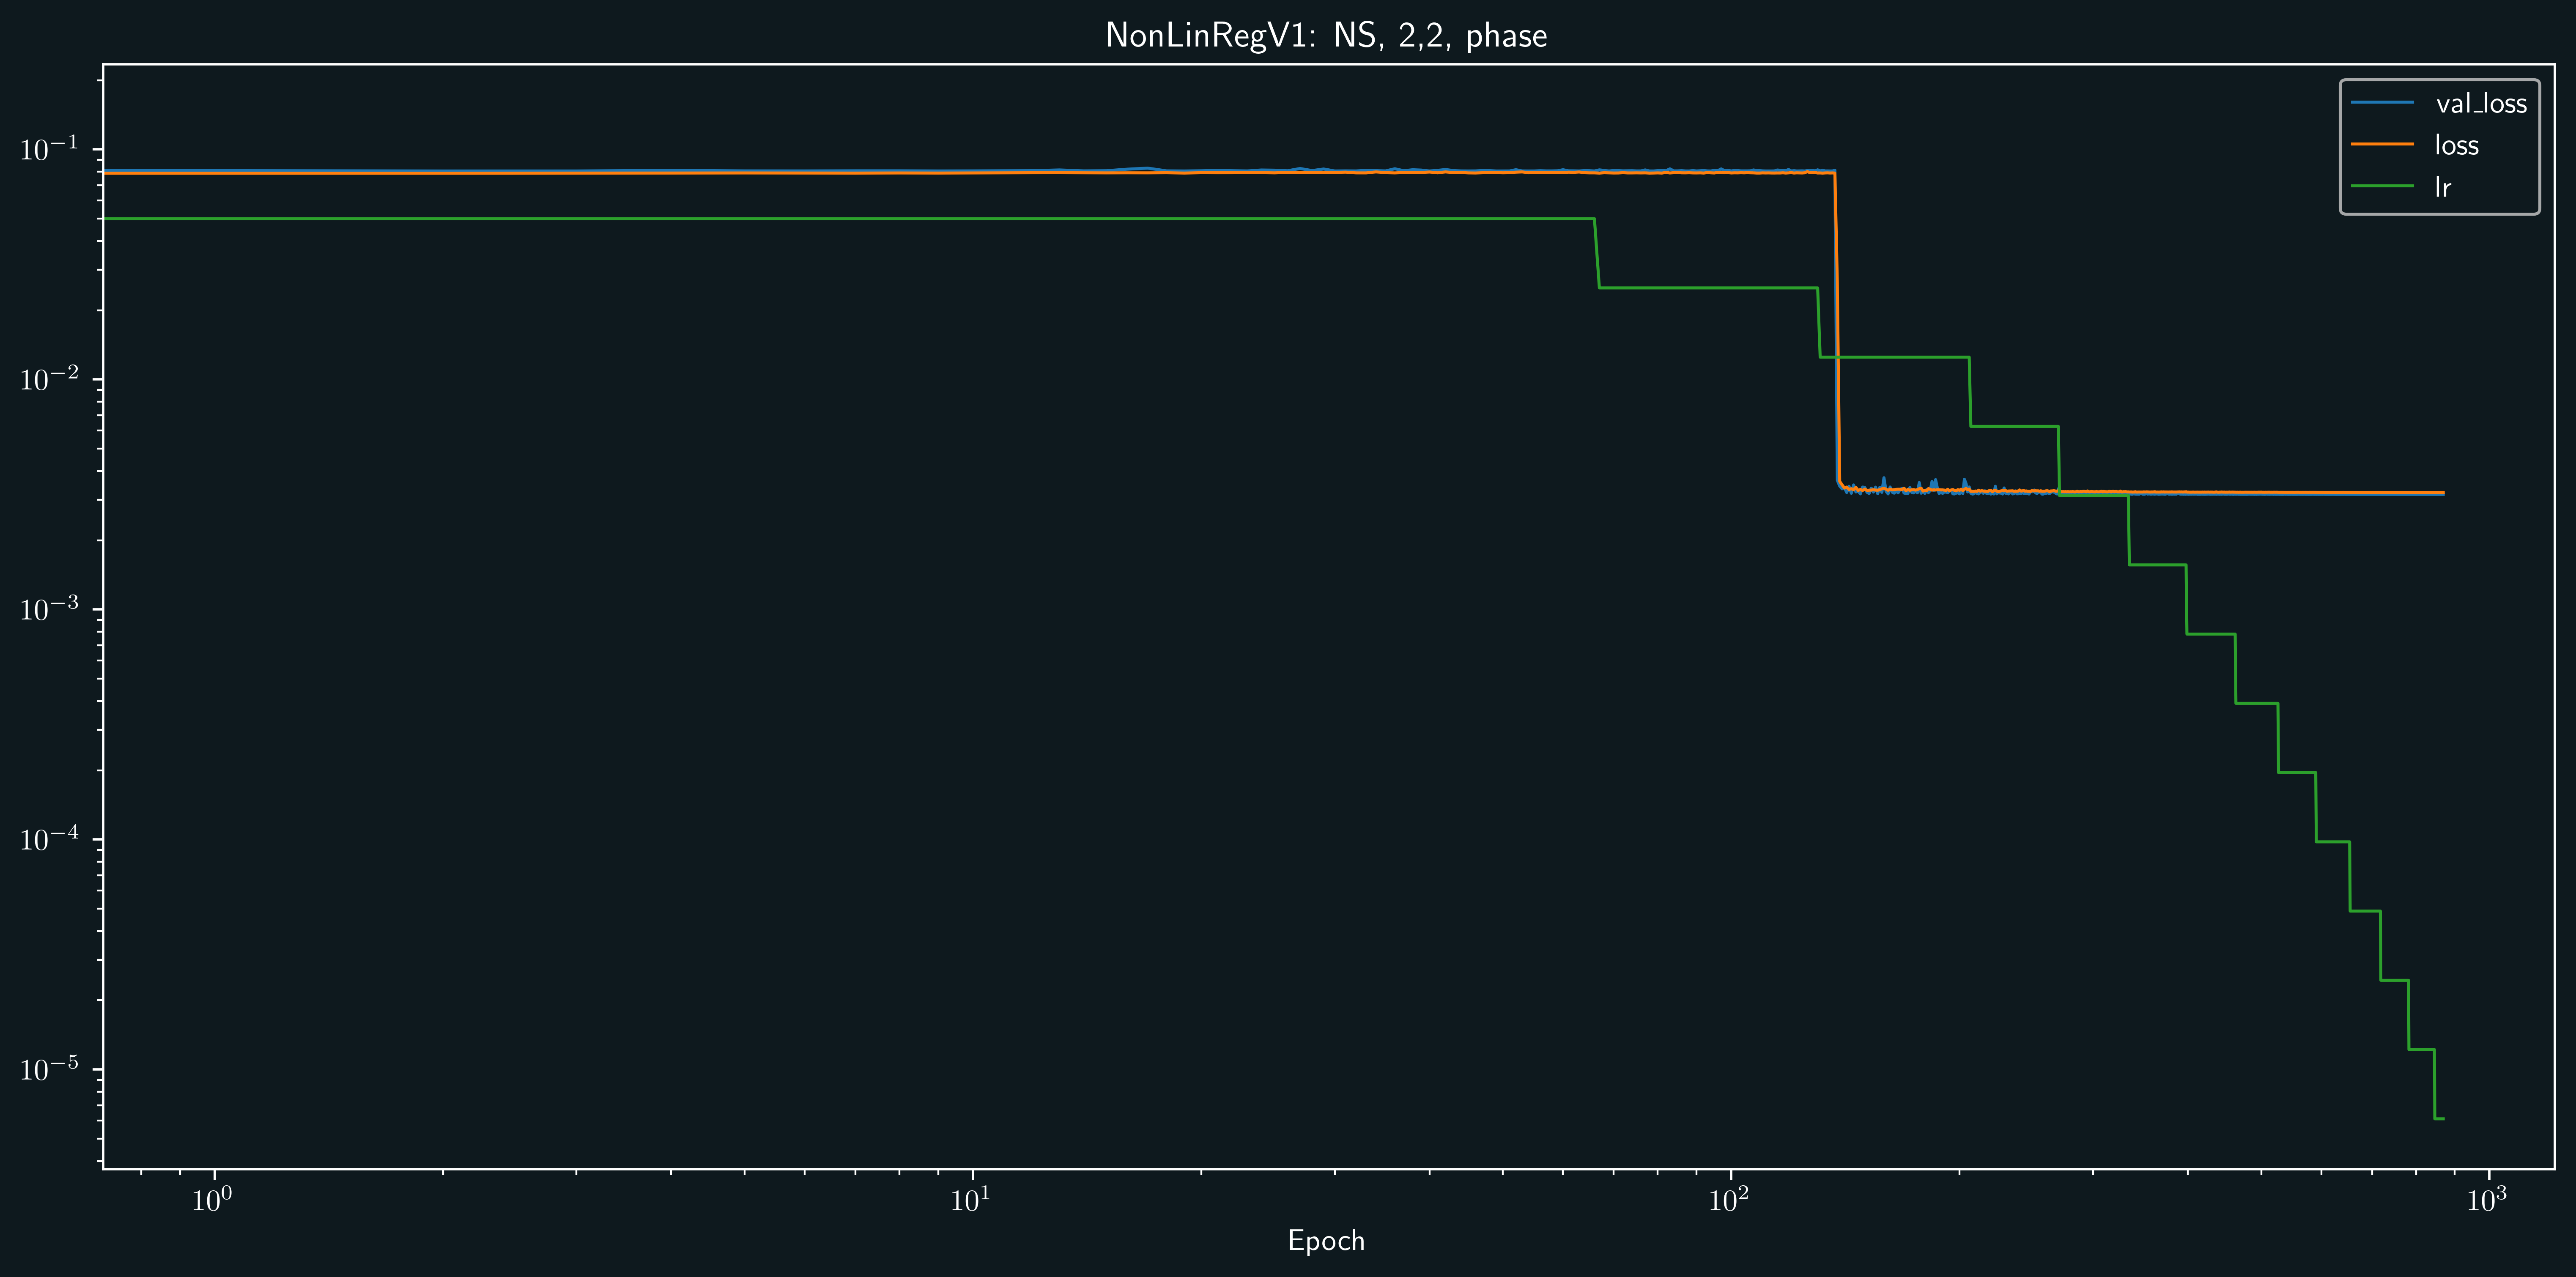

Saved training curve figure to /home/connor/projects/reduced-order-modelling-of-gravitational-waves/data/NS/train_xl/2,2/phase/models/NonLinRegV1/training_curve.png


In [ ]:
# ----- Train the model -----
print(hyper)
history = model.fit(x=X_train,
                    y=Y_train,
                    validation_data=(X_val, Y_val),
                    **hyper.fit,
                    callbacks=[lrop, early_stopping],
                    shuffle=True,
                    verbose=1)
print(f"Training of {model_name} complete.")

# ----- Visualise gradient descent -----
fig_file = model_dir / "training_curve.png"

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=512)

ax.loglog(history.history['val_loss'], label='val_loss')
ax.loglog(history.history['loss'], label='loss')
ax.loglog(history.history['learning_rate'], label='lr')

ymin = 10**np.floor(np.log10(ax.get_ylim()[0]))
ymax = 10**np.floor(np.log10(ax.get_ylim()[1]) + 1)
ax.set_ylim(ymin, ymax)

ax.set_title(f"{model_name}: {bbh_spin}, {mode}, {component}")
ax.set_xlabel("Epoch")
ax.legend()

fig.tight_layout()

plt.savefig(fig_file)
plt.show()
print(f"Saved training curve figure to {fig_file}")

In [26]:
# ===== Save model =====
model_file = model_dir / "model.keras"

model.save(filepath=model_file)
print(f"Saved model to {model_file}")

Saved model to /home/connor/projects/reduced-order-modelling-of-gravitational-waves/data/NS/train_xl/2,2/phase/models/NonLinRegV1/model.keras
